# Basic tutorial: image data
#### Author: Matteo Caorsi

This short tutorial provides you with the basic functioning of *giotto-deep* API.

The main steps of the tutorial are the following:
 1. creation of a dataset
 2. creation of a model
 3. define metrics and losses
 4. run benchmarks
 5. visualise results interactively

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

import torch
from torch import nn

from gdeep.models import FFNet

from gdeep.visualisation import  persistence_diagrams_of_activations

from torch.utils.tensorboard import SummaryWriter
from gdeep.data import TorchDataLoader


from gtda.diagrams import BettiCurve

from gtda.plotting import plot_betti_surfaces

No TPUs...
No TPUs...


# Initialize the tensorboard writer

In order to analyse the reuslts of your models, you need to start tensorboard.
On the terminal, move inside the `/example` folder. There run the following command:

```
tensorboard --logdir=runs
```

Then go [here](http://localhost:6006/) after the training to see all the visualisation results.

In [2]:
writer = SummaryWriter()

# Create your dataset

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler
dl = TorchDataLoader(name="CIFAR10")

# use only 320 images from cifar10
train_indices = list(range(32*10))
dl_tr, dl_ts = dl.build_dataloader(batch_size=32, sampler=SubsetRandomSampler(train_indices))

Files already downloaded and verified
Files already downloaded and verified


## Define and train your model

In [4]:
import torchvision.models as models
from gdeep.pipeline import Pipeline

model = nn.Sequential(models.resnet18(pretrained=True), nn.Linear(1000,10))

No TPUs...


In [5]:
from torch.optim import SGD

# print(model)
loss_fn = nn.CrossEntropyLoss()

pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)

# train the model
pipe.train(SGD, 2, False, {"lr":0.01}, {"batch_size":32})



Epoch 1
-------------------------------
Training loss:  3.6419260501861572  [ 10 / 10 ]                     
Time taken for this epoch: 4s
Validation results: 
 Accuracy: 0.2%,                 Avg loss: 0.006500 

Epoch 2
-------------------------------
Training loss:  1.2680631875991821  [ 10 / 10 ]                     
Time taken for this epoch: 5s
Validation results: 
 Accuracy: 0.2%,                 Avg loss: 0.010000 



(0.01, 0.19632547140121462)

# Simply use interpretability tools

In [6]:
from gdeep.analysis.interpretability import Interpreter

inter = Interpreter(model, method="IntegratedGradients")
inter.interpret_image(next(iter(dl_tr))[0][0].reshape(1,3,32,32), 6);


No TPUs...


# Extract inner data from your models

In [7]:
from gdeep.models import ModelExtractor

me = ModelExtractor(model, loss_fn)

lista = me.get_layers_param()

for k, item in lista.items():
    print(k,item.shape)


0.conv1.weight torch.Size([64, 3, 7, 7])
0.bn1.weight torch.Size([64])
0.bn1.bias torch.Size([64])
0.bn1.running_mean torch.Size([64])
0.bn1.running_var torch.Size([64])
0.bn1.num_batches_tracked torch.Size([])
0.layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
0.layer1.0.bn1.weight torch.Size([64])
0.layer1.0.bn1.bias torch.Size([64])
0.layer1.0.bn1.running_mean torch.Size([64])
0.layer1.0.bn1.running_var torch.Size([64])
0.layer1.0.bn1.num_batches_tracked torch.Size([])
0.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
0.layer1.0.bn2.weight torch.Size([64])
0.layer1.0.bn2.bias torch.Size([64])
0.layer1.0.bn2.running_mean torch.Size([64])
0.layer1.0.bn2.running_var torch.Size([64])
0.layer1.0.bn2.num_batches_tracked torch.Size([])
0.layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
0.layer1.1.bn1.weight torch.Size([64])
0.layer1.1.bn1.bias torch.Size([64])
0.layer1.1.bn1.running_mean torch.Size([64])
0.layer1.1.bn1.running_var torch.Size([64])
0.layer1.1.bn1.num_batches_tracked torch.

In [8]:
x = next(iter(dl_tr))[0][0]
if x.dtype is not torch.int64:
    res = me.get_decision_boundary(x, n_epochs=1)
    res.shape

Executing the decision boundary computations:


In [9]:
x = next(iter(dl_tr))[0]
list_activations = me.get_activations(x)
len(list_activations)


78

In [10]:
x, target = next(iter(dl_tr))
if x.dtype is torch.float:
    for gradient in me.get_gradients(x, target=target)[1]:
        print(gradient.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
t

# Visualise activations and other topological aspects of your model

In [11]:
from gdeep.visualisation import Visualiser

vs = Visualiser(pipe)

# vs.plot_data_model()
# vs.plot_activations(x)
vs.plot_persistence_diagrams(x)


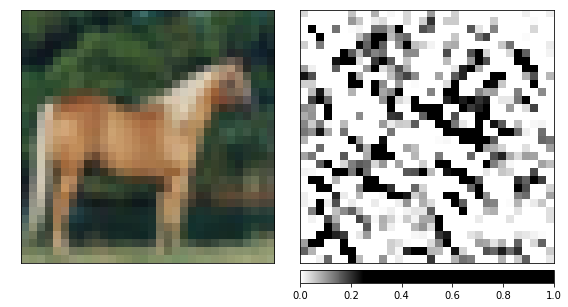

In [12]:
vs.plot_interpreter_image(inter);